### In this notebook, we will briefly introduce how we performed image segmentation using a pretrained 2-channel Attention-Residual Unet model and cell feature extraction using a bespoke program called momia (now updated to the unpublished version 2)

In [11]:
import momia2 as mo
import tensorflow as tf
import os, glob

### Load pre-trained Attention-Residual Unet model

In [8]:
model = tf.keras.models.load_model('./Important_References/AttResUnet_20221229_2channel_512/')

2024-02-18 19:51:22.516205: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-18 19:51:22.516236: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-18 19:51:22.516241: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-18 19:51:22.516289: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-18 19:51:22.516312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/jzrolling/miniconda3/envs/tensorflow_env/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: unet is not loaded, but a Lambda layer uses it. 

In [9]:
def image2predict(img, model, size=256, channels=3, pad=16, batch_size=5):
    shape = img.shape[:2]
    patchifier = mo.segment.mask.Patchifier(shape, size, pad)
    patches = patchifier.pachify(img)
    pred = model.predict(patches, batch_size=batch_size)
    stitched = patchifier.unpatchify(pred, channels)
    return stitched

### Image segmentation and cellular feature extraction

In [20]:
for f in sorted(glob.glob('./Microscopy_demo/*.nd2')):
    #load nd2 file
    mio = mo.momia_IO.ImageLoader(f)
    #iterate over imaging fields
    n=0
    for i in range(mio.n_fields):
        n+=1
        out_file = './Microscopy_demo/{}_{}.pk'.format(f.split('/')[-1].split('.')[0],n)
        if not os.path.isfile(out_file):
            #load data
            data = {'FITC':mio.get_slice(position=i,channel=0),
                    'Phase_Ian':mio.get_slice(position=i,channel=1)}
            p = mo.Patch(image_dict=data,ref_channel='Phase_Ian')
            p.crop_edge(edge_fraction=0.2)
            #p.correct_xy_drift(reference_channel='Phase_Ian')
            pred = image2predict(mo.utils.normalize_image(p.get_ref_image(),mask=1),
                              model,size=512,pad=12,channels=2)
            p.labeled_mask = mo.segment.dist2labels_simp(pred[:,:,0],
                                                         pred[:,:,1],dist_threshold=0.25)
            p.locate_particles()
            p.find_outline(approximate=True,tolerance=0.9,interp_distance=1,
                       smooth_level=8,
                       level=0.2,dilation=False,erosion=False,
                       use_binary=True)
            p.extract_midlines()
            p.get_morphology_stats()
            p.get_intensity_stats()
            # remove cells which don't look like Msm using emperical criteria
            p.filter_particles(filter_dict={'solidity':(0.5,1),
                                            'min_negative_curvature':(-60,40),
                                            'branched':(-1,0.5)})
            mo.momia_IO.pickle_save(p,out_file)

2/2 [==============================] - 1s 661ms/step


Rendering cell plot(s)...


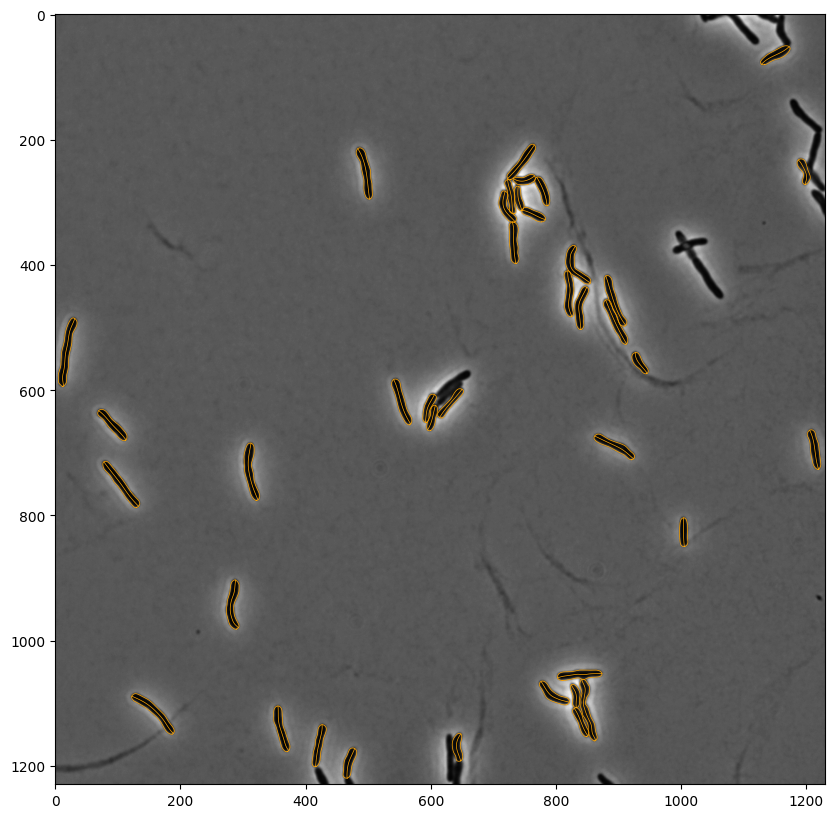

In [38]:
# load an analyzed momia.Patch object
p=mo.momia_IO.pickle_load('./Microscopy_demo/HW84_RAPA-_1.pk')
# plot segmentation result
p.plot(figsize=(10,10),
       outline_prop={'lw':0.5,'color':'orange'},
       midline_prop={'lw':0.5,'color':'orange'})

Rendering cell plot(s)...


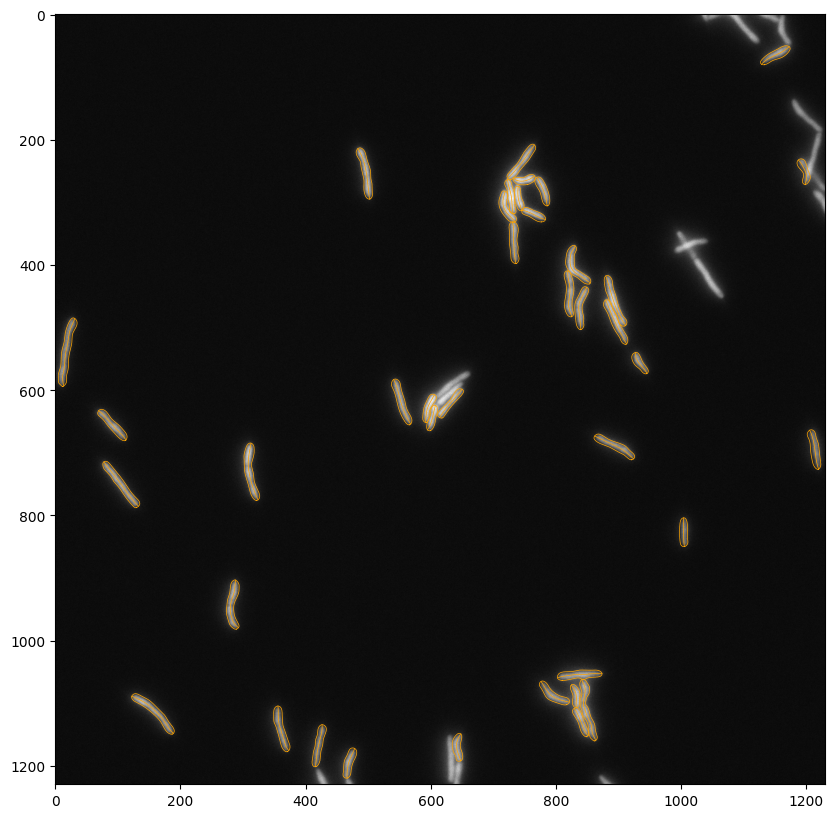

In [39]:
# and also the fluorescent channel
p.plot(figsize=(10,10),channel='FITC',
       outline_prop={'lw':0.5,'color':'orange'},
       midline_prop={'lw':0.5,'color':'orange'})

In [43]:
# Cell coordinates and numeric features are stored as a pandas.Dataframe object
# Here we only list out the first 5 cells which are "included" for downstream analysis after particle filteration
p.regionprops[p.regionprops['$include']==True].head()

,$bbox-0,$bbox-1,$bbox-2,$bbox-3,$coords,$centroid-0,$centroid-1,area,convex_area,filled_area,eccentricity,solidity,major_axis_length,minor_axis_length,perimeter,equivalent_diameter,extent,orientation,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,weighted_moments_hu-0,weighted_moments_hu-1,weighted_moments_hu-2,weighted_moments_hu-3,weighted_moments_hu-4,weighted_moments_hu-5,weighted_moments_hu-6,mean_intensity,max_intensity,min_intensity,compactness,...,$touching_edge,$include,$midlines,$outline,$refined_outline,$widths_list,$mask,min_negative_curvature,max_positive_curvature,mean_curvature,Q1_curvature,Q3_curvature,length [µm],width_median [µm],width_std [µm],width_max [µm],width_Q1 [µm],width_Q3 [µm],sinuosity,branched,FITC_mean,FITC_median,FITC_max,FITC_min,FITC_Q1,FITC_Q3,FITC_std,FITC_CV,FITC_skewness,FITC_kurtosis,Phase_Ian_mean,Phase_Ian_median,Phase_Ian_max,Phase_Ian_min,Phase_Ian_Q1,Phase_Ian_Q3,Phase_Ian_std,Phase_Ian_CV,Phase_Ian_skewness,Phase_Ian_kurtosis
$label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,50,1127,81,1175,"[[50, 1166], [51, 1163], [51, 1164], [51, 1165...",64.635314,1151.074257,606.0,660.0,606.0,0.967315,0.918182,55.772395,14.142698,122.953319,27.777386,0.407258,-1.087219,155.085245,74.880510,74.880510,51.825750,0.341437,0.090108,0.000602,0.000364,1.704664e-07,0.000109,-2.404206e-09,0.000095,6.758447e-09,1.696074e-14,1.198652e-14,1.697819e-28,9.785664e-19,1.958672e-29,3871.155116,8880.0,2384.0,1.985171,...,0,1,"[[[37.511321044246024, 9.25347846364946], [36....","[[38.11539007141349, 13.835292603149773], [38....",[],"[0.8160932580141299, 0.15683693704446092, 0.97...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-4.185832,73.280554,22.914462,4.780388,38.447253,3.446014,0.816093,0.156837,0.972721,0.727147,0.923629,1.0,0,1208.046205,1228.5,1802.0,407.0,974.50,1486.75,323.525747,0.267809,-0.294216,-0.765291,3871.155116,3184.0,8880.0,2384.0,2900.0,4484.0,1472.087572,0.380271,1.449444,1.188413
10,207,722,265,768,"[[207, 762], [207, 763], [208, 761], [208, 762...",235.365229,745.576819,742.0,831.0,742.0,0.984968,0.892900,75.699177,13.076139,154.793939,30.736684,0.278111,-0.652825,138.890999,167.659458,167.659458,229.943427,0.497081,0.219283,0.001090,0.000492,3.467886e-07,0.000174,9.984650e-08,0.000138,1.630022e-08,1.756711e-14,2.787582e-15,-5.891792e-31,-1.603746e-19,-1.949815e-29,3715.579515,9504.0,2224.0,2.569769,...,0,1,"[[[9.175092157681203, 51.44274836997407], [10....","[[64.64429510128768, 13.803452502375654], [64....",[],"[0.7399714598514485, 0.08909131070808138, 0.85...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-5.599033,72.837056,17.832681,1.050499,31.282395,4.466561,0.739971,0.089091,0.850232,0.681117,0.787419,1.0,0,1470.024259,1521.5,2172.0,585.0,1234.25,1722.75,327.548856,0.222819,-0.413970,-0.580959,3715.579515,3136.0,9504.0,2224.0,2656.0,4396.0,1435.552625,0.386360,1.425517,1.475190
11,213,482,295,507,"[[213, 487], [213, 488], [214, 484], [214, 485...",252.842544,495.801877,959.0,1160.0,959.0,0.987678,0.826724,92.949703,14.546449,186.568542,34.943336,0.467805,0.189015,31.821018,-97.209680,-97.209680,521.381881,0.576854,0.301701,0.003528,0.000435,-3.215632e-07,-0.000176,4.314904e-07,0.000169,2.525057e-08,9.416948e-14,1.098611e-14,-2.872097e-28,-1.586823e-18,-2.058541e-28,3469.113660,8224.0,2208.0,2.888340,...,0,1,"[[[9.112393344811103, 9.340766679426869], [10....","[[89.58132306097566, 28.892786327837893], [89....",[],"[0.8165880998770053, 0.09597397440533449, 0.90...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-9.144730,69.461716,14.823007,-0.396719,26.488329,5.431052,0.816588,0.095974,0.908440,0.748086,0.855789,1.0,0,1416.543274,1483.0,2024.0,518.0,1132.50,1704.00,342.904009,0.242071,-0.439921,-0.876109,3469.113660,2864.0,8224.0,2208.0,2528.0,4064.0,1323.835403,0.381606,1.378762,0.874332
12,231,1186,272,12